In [1]:
import pandas as pd
from pyspark.sql import SparkSession

from pyspark.sql.functions import *

INPUT_PATH = "../data/processed/"
VERSION = "v1"


In [2]:
spark = SparkSession.builder.appName("ds-classify").getOrCreate()
dataset = spark.read.parquet(f"{INPUT_PATH}/dataset_{VERSION}")
dataset.show()

24/02/25 07:47:54 WARN Utils: Your hostname, AGM-595277.local resolves to a loopback address: 127.0.0.1; using 192.168.0.166 instead (on interface en0)
24/02/25 07:47:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/25 07:48:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+----------+----------------------+---------------+-----+-------------+------+-------+----------+----+---+---+
|    id| uf|  sentido_via|       tipo_acidente|   km|    causa_acidente| br|   fase_dia|estado_fisico|condicao_metereologica|tipo_pista|ano_fabricacao_veiculo|   tipo_veiculo|idade|         sexo|mortos|feriado|      date| ano|mes|dia|
+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+----------+----------------------+---------------+-----+-------------+------+-------+----------+----+---+---+
|260497| SC|    Crescente|    Colisão traseira| 36,8|Ingestão de Álcool|101|Plena Noite|Não Informado|               Nublado|     Dupla|                    NA|       Caminhão|   NA|Não Informado|     0|   NULL|2020-01-03|2020|  1|  3|
|260687| SP|  Decrescente|     Colisão frontal|   46|Ingestã

In [3]:
dataset.count()

51315

## Removendo Ignorado e Não Informado

In [4]:
dataset = dataset.filter(col('sexo').isin(['Masculino', 'Feminino'])) 

## Selecionando somente acidentes por ingestão de álcool

In [5]:
dataset = dataset.filter(col('causa_acidente').isin(['Ingestão de Álcool', 'Ingestão de álcool pelo condutor'])) 

## Agrupa condição metereológica

In [6]:
condicoes_normais = ["Céu Claro", "Sol"]

dataset = dataset.withColumn("clima", 
                   when(col('condicao_metereologica').isin(condicoes_normais), "normal").otherwise("adverso")
)

## Feriados

In [7]:
dataset = dataset.withColumn("feriado", 
                   when(col('feriado').isNull(), "nao").otherwise("sim")
)

In [8]:
dataset = dataset.withColumn("idade", when(dataset.idade == "NA", None) \
      .otherwise(dataset.idade))
dataset.show()

+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+----------+----------------------+---------------+-----+---------+------+-------+----------+----+---+---+-------+
|    id| uf|  sentido_via|       tipo_acidente|   km|    causa_acidente| br|   fase_dia|estado_fisico|condicao_metereologica|tipo_pista|ano_fabricacao_veiculo|   tipo_veiculo|idade|     sexo|mortos|feriado|      date| ano|mes|dia|  clima|
+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+----------+----------------------+---------------+-----+---------+------+-------+----------+----+---+---+-------+
|260687| SP|  Decrescente|     Colisão frontal|   46|Ingestão de Álcool|101|Plena Noite|        Ileso|             Céu Claro|   Simples|                  2008|       Caminhão|   25|Masculino|     0|    nao|2020-01-03|2020|  1|  3| normal|
|260887| PE|  Decrescente|    Colisão trasei

In [9]:
dataset = dataset.filter((col('idade') >= 15) & (col('idade') <= 100))


In [10]:
from pyspark.sql.functions import floor, concat, lit

dataset = dataset.withColumn("grupo_idade", concat(floor(col("idade") / 15) * 15, lit("-"), (floor(col("idade") / 15) * 15 + 15)))

(dataset.groupBy("grupo_idade")
    .count()
).toPandas().sort_values(by="grupo_idade")

grupo_idade  count
1       15-30  12734
4       30-45  18467
3       45-60  10428
2       60-75   2958
5       75-90    205
0      90-105      8

## Fase do Dia

In [11]:
fases_dia = ["Plena Noite", "Anoitecer"]

dataset = dataset.withColumn("periodo", 
                   when(col('fase_dia').isin(fases_dia), "noturno").otherwise("diurno")
)

## Tipo da estrada

In [12]:
dataset = dataset.withColumn("tipo_pista", 
                   when(col('tipo_pista') != "Simples", "nao_simples").otherwise("simples")
)

In [13]:
dataset.groupBy('sexo').count().show()

+---------+-----+
|     sexo|count|
+---------+-----+
| Feminino| 8091|
|Masculino|36709|
+---------+-----+



Pelo o sexo tiver somente o sexo, a feature foi removida do modelo

In [14]:
dataset.show()

+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+-----------+----------------------+---------------+-----+---------+------+-------+----------+----+---+---+-------+-----------+-------+
|    id| uf|  sentido_via|       tipo_acidente|   km|    causa_acidente| br|   fase_dia|estado_fisico|condicao_metereologica| tipo_pista|ano_fabricacao_veiculo|   tipo_veiculo|idade|     sexo|mortos|feriado|      date| ano|mes|dia|  clima|grupo_idade|periodo|
+------+---+-------------+--------------------+-----+------------------+---+-----------+-------------+----------------------+-----------+----------------------+---------------+-----+---------+------+-------+----------+----+---+---+-------+-----------+-------+
|260687| SP|  Decrescente|     Colisão frontal|   46|Ingestão de Álcool|101|Plena Noite|        Ileso|             Céu Claro|    simples|                  2008|       Caminhão|   25|Masculino|     0|    nao|2020-01-03|20

In [15]:
from pyspark.sql.types import IntegerType

dataset = dataset.withColumn("morreu", col("mortos").cast(IntegerType()))

In [39]:
NUMERIC_FEATURES = []
CATEGORICAL_FEATURES = ['uf', 'periodo', 'clima','tipo_pista', 'tipo_veiculo', 'grupo_idade', 'sexo', 'feriado']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET = "morreu"
COLUNMS = FEATURES + [ TARGET ]

In [40]:
df = dataset.select(COLUNMS).toPandas()

## Criando Dataset

In [41]:
from src.data.dataset import Dataset

dataset_train = Dataset(
    data=df,
    features=FEATURES,
    target=TARGET,
    test_size=0.2,
)

dataset_validation = dataset_train.get_validation_data()

In [42]:
print("{} training instances ".format(len(dataset_train.training[0])))
print("{} testing instances ".format(len(dataset_train.testing[0])))
print("{} validation instances ".format(len(dataset_validation.testing[0])))

35840 training instances 
8960 testing instances 
3584 validation instances 


## Pre Processamento

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ]
)

## Training


In [44]:
from src.models.train_model import Trainer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

models = {
    "Baseline": DummyClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

 ### Treinamento sem Downsample

In [45]:

trainer = Trainer(models=models, preprocessor=preprocessor)
trainer.train(dataset=dataset_train)

------------------- Resultados ----------------------------
Baseline Score: 0.97
Baseline CV Score: 0.97
Decision Tree Score: 0.97
Decision Tree CV Score: 0.96
Random Forest Score: 0.97
Random Forest CV Score: 0.97
Gradient Boost Score: 0.97
Gradient Boost CV Score: 0.97
XGBoost Score: 0.97
XGBoost CV Score: 0.97


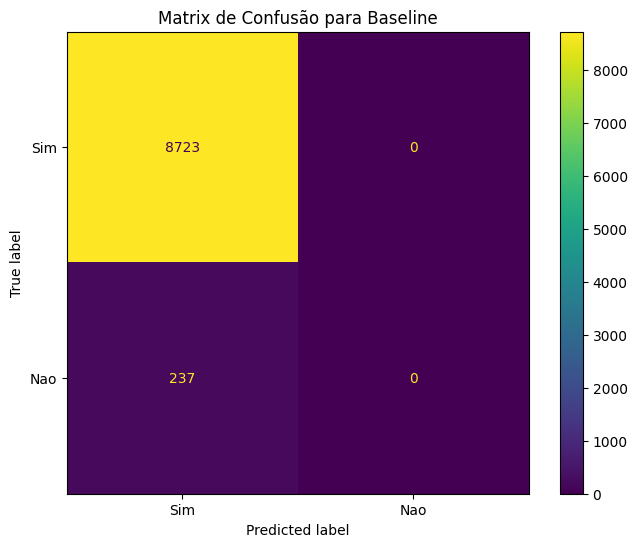

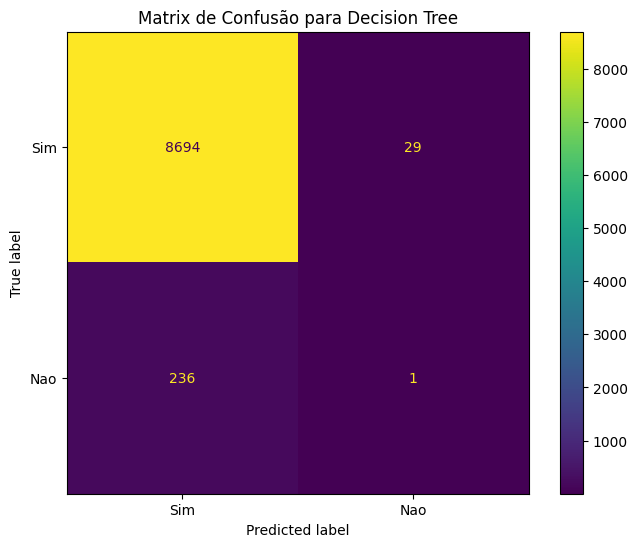

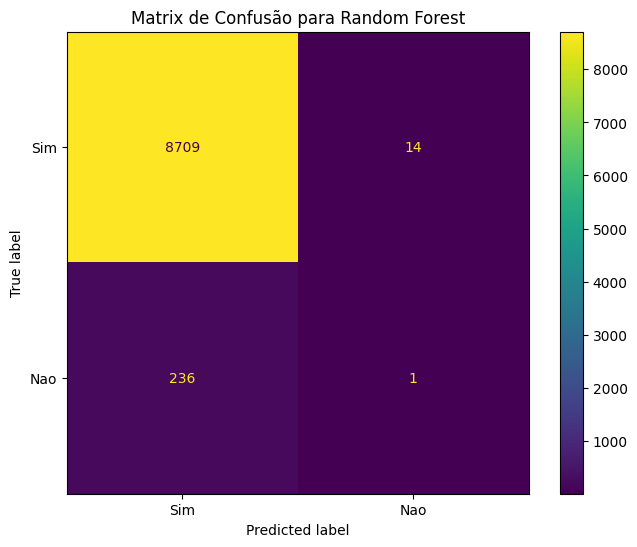

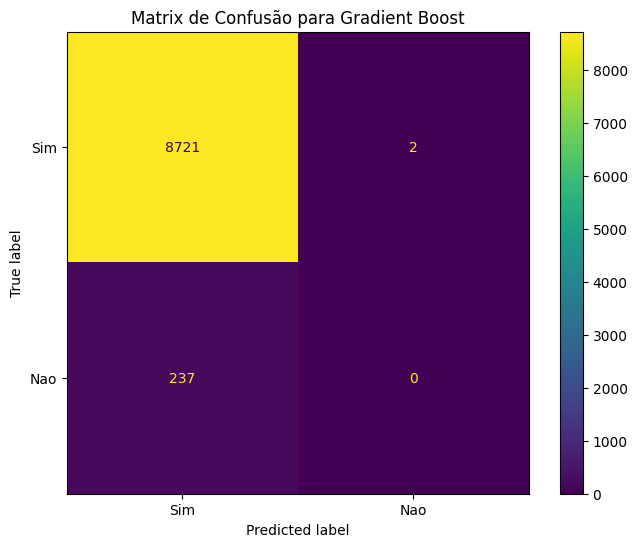

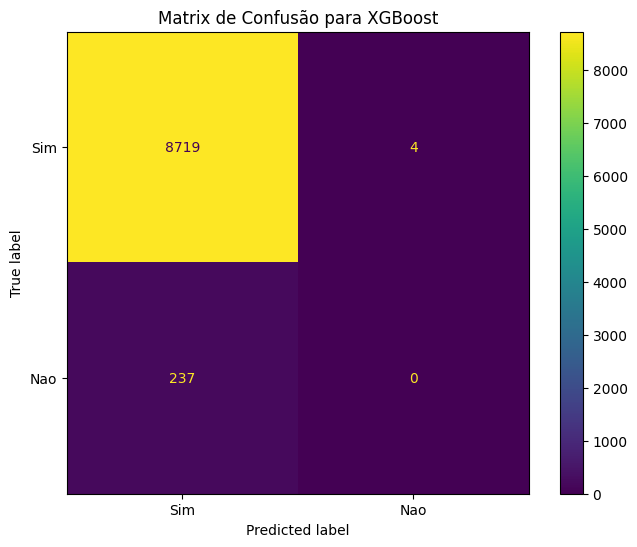

In [46]:
trainer.plot_results()

### Treinamento com Downsample


<Axes: xlabel='morreu'>

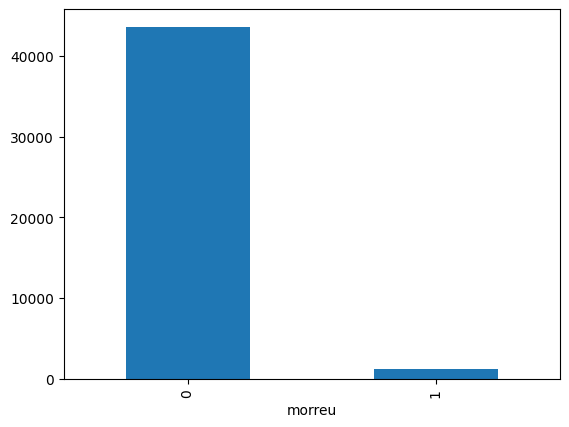

In [47]:
df['morreu'].value_counts().plot(kind='bar')


In [48]:
majority_sample = df[df.morreu==0]
minority_sample = df[df.morreu==1]

print("O tamanho da amostra minoritária é: {}".format(len(minority_sample)))
print("O tamanho da amostra majoritária é: {}".format(len(majority_sample)))

O tamanho da amostra minoritária é: 1194
O tamanho da amostra majoritária é: 43606


<Axes: xlabel='morreu'>

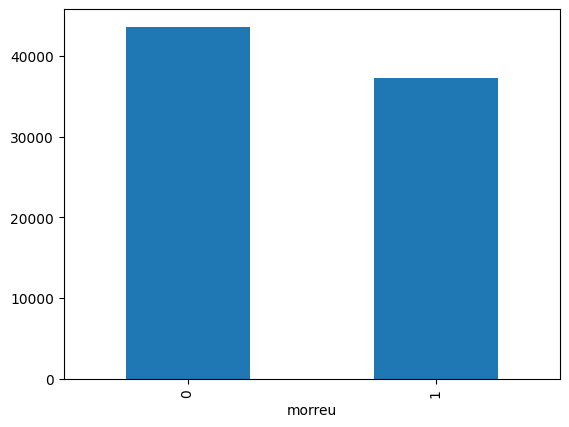

In [49]:
from sklearn.utils import resample

minority_sample = resample(minority_sample, replace=True,
                             n_samples=37290,
                             random_state=42)

data_downsampled = pd.concat([majority_sample, minority_sample])
 
data_downsampled.morreu.value_counts().plot(kind='bar')


In [50]:
dataset_train_downsampled = Dataset(
    data=data_downsampled,
    features=FEATURES,
    target=TARGET,
    test_size=0.2,
)

dataset_validation_dowmsampled = dataset_train_downsampled.get_validation_data()

In [51]:
trainer = Trainer(models=models, preprocessor=preprocessor)
trainer.train(dataset=dataset_train_downsampled)

------------------- Resultados ----------------------------
Baseline Score: 0.54
Baseline CV Score: 0.54
Decision Tree Score: 0.84
Decision Tree CV Score: 0.81
Random Forest Score: 0.84
Random Forest CV Score: 0.82
Gradient Boost Score: 0.72
Gradient Boost CV Score: 0.71
XGBoost Score: 0.79
XGBoost CV Score: 0.77


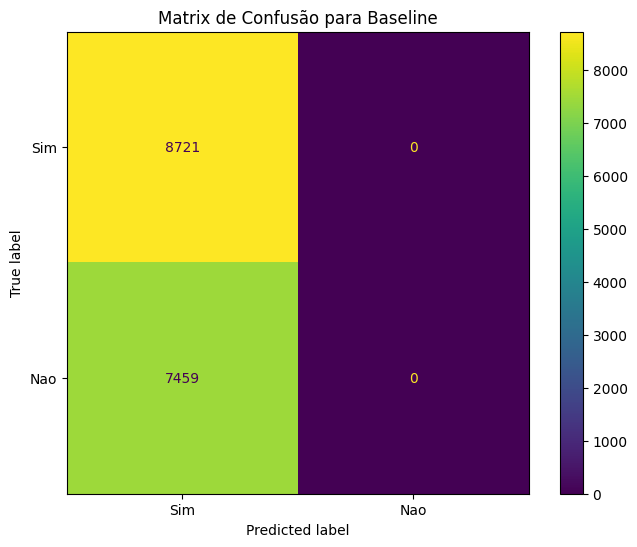

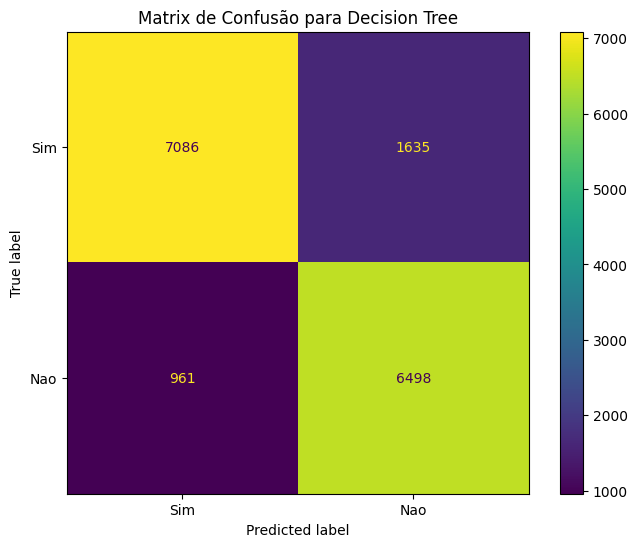

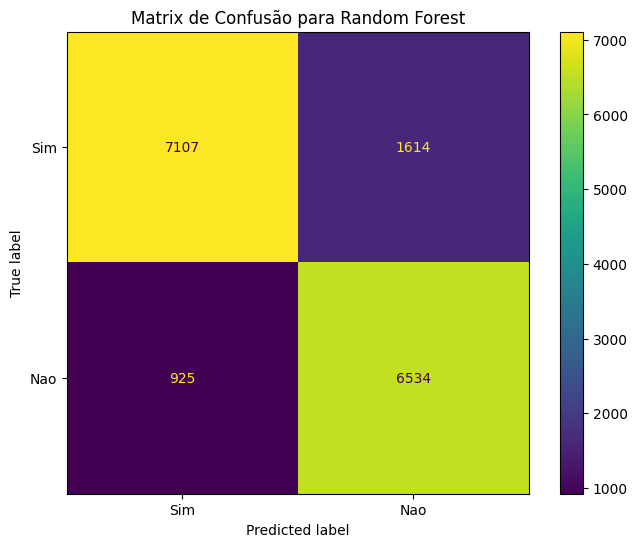

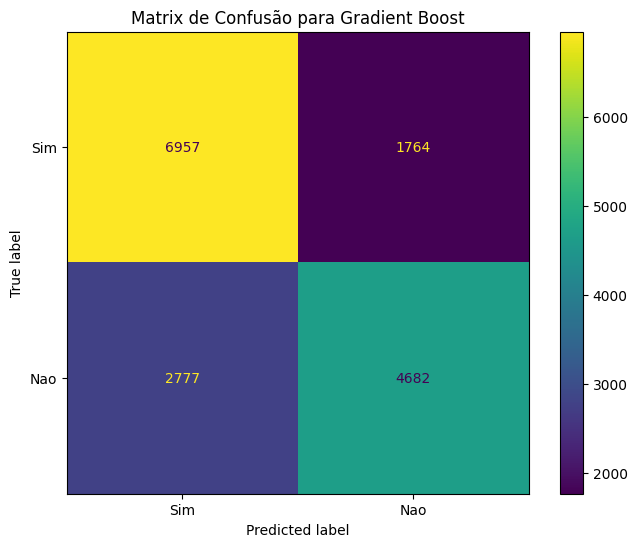

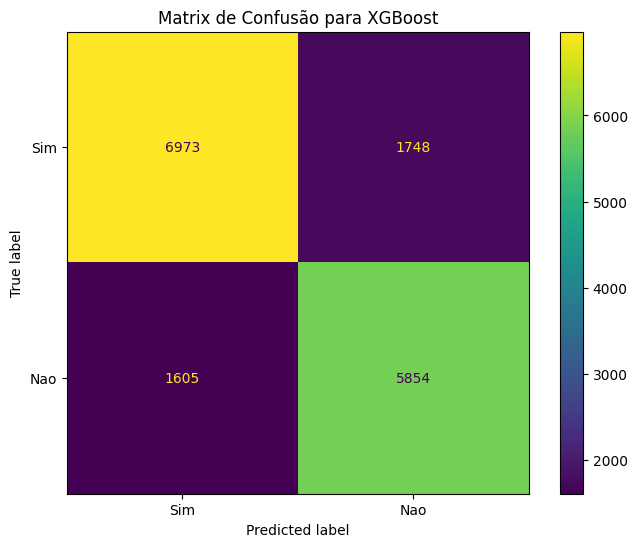

In [52]:
trainer.plot_results()

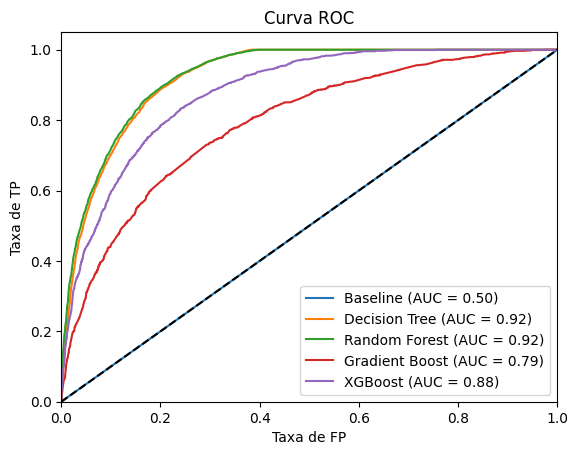

In [53]:
trainer.plot_roc_auc()

In [54]:
pipeline = trainer.get_model("Random Forest")

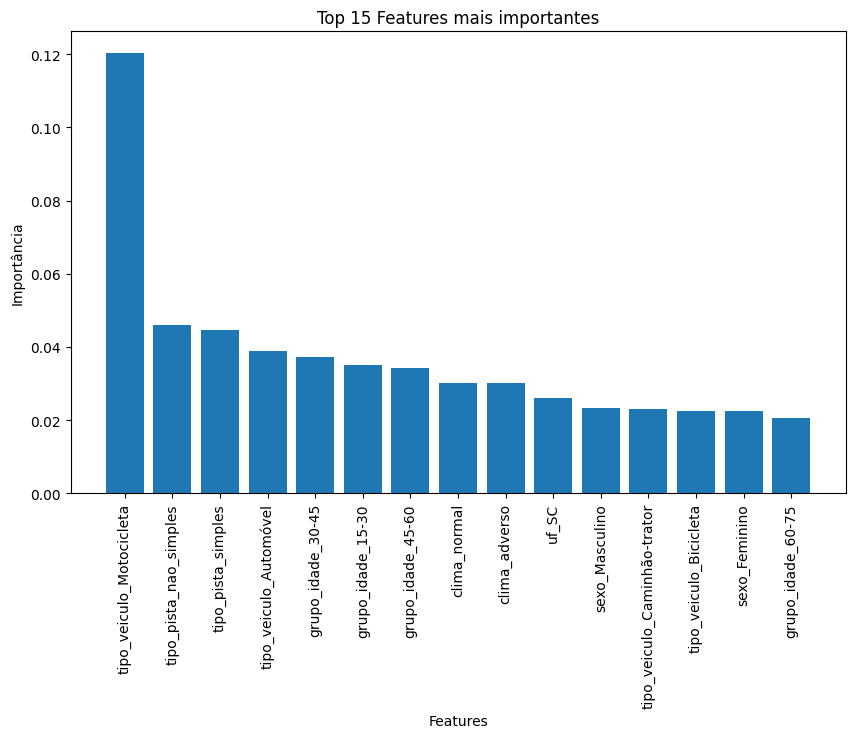

In [55]:
import matplotlib.pyplot as plt

feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=CATEGORICAL_FEATURES)

importance = {feature: importance for feature, importance in zip(feature_names, feature_importances)}
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1] if x[1] is not None else float('-inf'), reverse=True))

feature_names = list(sorted_importance.keys())[:15]
feature_importances = list(sorted_importance.values())[:15]
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Top 15 Features mais importantes')
plt.xticks(rotation=90)
plt.show()


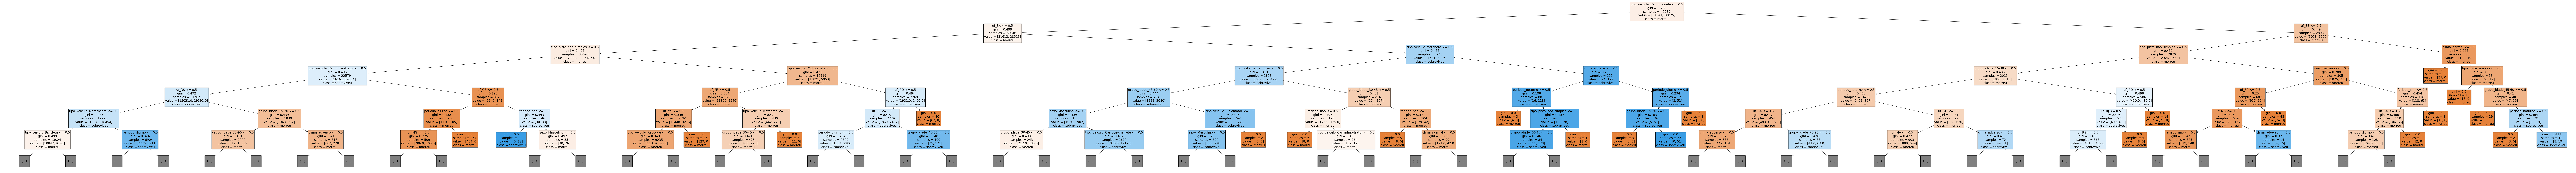

In [56]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


tree = pipeline.named_steps['classifier'].estimators_[0]
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=CATEGORICAL_FEATURES)

plt.figure(figsize=(300, 20)) 
plot_tree(tree, max_depth=6, feature_names=feature_names, fontsize=20, class_names=["morreu", "sobreviveu"],filled=True)

plt.show()


In [57]:
import joblib

joblib.dump(pipeline, "../models/accident_classifier.sav")

['../models/accident_classifier.sav']

In [58]:
payload = dataset_train.data.head(1)

In [59]:
payload["uf"] = "SP"
payload["feriado"] = "nao"
payload["tipo_pista"] = "nao_simples"

/var/folders/kn/g36yjhrn3g7d3p20b9r5f7580000gn/T/ipykernel_12117/1483136262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payload["uf"] = "SP"
/var/folders/kn/g36yjhrn3g7d3p20b9r5f7580000gn/T/ipykernel_12117/1483136262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payload["feriado"] = "nao"
/var/folders/kn/g36yjhrn3g7d3p20b9r5f7580000gn/T/ipykernel_12117/1483136262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [60]:
payload

uf  periodo   clima   tipo_pista tipo_veiculo grupo_idade       sexo  \
0  SP  noturno  normal  nao_simples     Caminhão       15-30  Masculino   

  feriado  morreu  
0     nao       0

In [61]:
pipeline.predict_proba(payload)

array([[1., 0.]])

24/02/25 11:22:50 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1032463 ms exceeds timeout 120000 ms
24/02/25 11:22:50 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/25 11:38:02 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 